#Importing libraries

In [ ]:

import shutil
import codecs
import imageio
import array 
import numpy as np
from tqdm import tqdm

from scipy.sparse import csr_matrix
from scipy.sparse import save_npz
from scipy.sparse import vstack
from sklearn.preprocessing import normalize
import scipy.sparse
import multiprocessing
from multiprocessing import Process
from numpy import savetxt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

import pandas as pd
import os
from scipy.sparse import load_npz

In [ ]:
! pip3 install xgboost

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier

# Kaggle file import

In [ ]:
api_token = files.upload()

In [ ]:
!pip install kaggle

api_token = {"username":"xxxxxxx","key":"xxxxxxxxxxxxxxxxx"}

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle competitions download -f 'train.7z' 'malware-classification'

100% 17.5G/17.5G [01:54<00:00, 222MB/s]
100% 17.5G/17.5G [01:54<00:00, 165MB/s]


##we are only extracting byte file 

In [ ]:
!7z e train.7z -o/content/byteFiles *.bytes -r


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs AMD EPYC 7B12 (830F10),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 18810691091 bytes (18 GiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 18810691091
Headers Size = 339764
Method = LZMA:24
Solid = +
Blocks = 94

  0%      0% . train/kQEbWRHa04gOYDqM1NJ6.asm                                       0% 1 . train/KqEgONxfHdP5lLaBIGQk.asm                                         0% 2 . train/kqiOdVbRQlB2s907GLMv.asm                                         0% 5 . train/kQsiVxDbAXt23wRWal57.asm           

#Byte bigram feature

##Creating txt files

In [ ]:
files = os.listdir('byteFiles')
filenames=[]
for file in tqdm(files):
    if(file.endswith("bytes")):
        filenames.append(file)
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
                
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()

100%|██████████| 10868/10868 [37:27<00:00,  4.84it/s]


##Bi-gram
The highest possible bigram is "ffff" it binary value is 65535

We will calculate the decimal value of the byte code and store the count of that bi-gram in the index which is the decimal value.
For that we will create a large np array with columns of 16**4 which is 65536

In [ ]:
files = os.listdir('byteFiles')
with open("file_names.txt","w+") as fp:
    for file in files:
        fp.write("%s\n"%file)
fp.close()



In [ ]:
shutil.move("/content/file_names.txt","/content/drive/MyDrive/Colab Notebooks/assignment files")

'/content/drive/MyDrive/Colab Notebooks/assignment files/file_names.txt'

###Creating bigrams for first half of the data

In [ ]:

bi_gram_matrix = np.zeros((int(len(files)/2),16**4))
files2 = files[:int(len(files)/2)] #half
for idx,file in enumerate(tqdm(files2)):
    
    
    if file.endswith("txt"): #if file is txt
        with open('byteFiles/'+file,"r") as bytefile: #read file
            #creating bigrams
            for line in bytefile: #for each line
                hex = line.split() #hexadecimal values
                bigram_hex = hex[:-1] # hex values except last value
                for i in range(len(bigram_hex)):
                    bigram_hex[i] += hex[i+1]#bigrams list
                
                decimal = [] #decimal values of bigrams
                for i in bigram_hex:
                    if "??" not in i:
                        decimal += [int(i,16)] #converting into decimal
                for i in decimal:
                    bi_gram_matrix[idx,i] += 1 #adding to bigram matrix
                
        bytefile.close()
        os.remove('byteFiles/'+file) #removing the txt after after processing
        
        
    
        
    




100%|██████████| 5434/5434 [1:43:03<00:00,  1.14s/it]


In [ ]:

bi_gram_matrix = csr_matrix(bi_gram_matrix) #converiting into sparse matrix
save_npz('sparse_byte_matrix1.npz', bi_gram_matrix) #saving sparse matrix in npz 

###Second half

In [ ]:
bi_gram_matrix = np.zeros((int(len(files)/2),16**4))
files2 = files[5434:]
for idx,file in enumerate(tqdm(files2)):
    
    
    if file.endswith("txt"):
        with open('byteFiles/'+file,"r") as bytefile:
            #creating bigrams
            for line in bytefile:
                hex = line.split()
                bigram_hex = hex[:-1]
                for i in range(len(bigram_hex)):
                    bigram_hex[i] += hex[i+1]#bigrams list
                
                decimal = [] #decimal values of bigrams
                for i in bigram_hex:
                    if "??" not in i:
                        decimal += [int(i,16)]
                for i in decimal:
                    bi_gram_matrix[idx,i] += 1
                
        bytefile.close()
        os.remove('byteFiles/'+file)

100%|██████████| 5434/5434 [1:46:33<00:00,  1.18s/it]


In [ ]:
bi_gram_matrix = csr_matrix(bi_gram_matrix)
save_npz('sparse_byte_matrix2.npz', bi_gram_matrix)

In [ ]:
#moving files to drive
shutil.move("/content/sparse_byte_matrix1.npz","/content/drive/MyDrive/Colab Notebooks/assignment files")
shutil.move("/content/sparse_byte_matrix2.npz","/content/drive/MyDrive/Colab Notebooks/assignment files")

first_half = load_npz("/content/drive/MyDrive/Colab Notebooks/assignment files/sparse_byte_matrix1.npz")
second_half = load_npz("/content/drive/MyDrive/Colab Notebooks/assignment files/sparse_byte_matrix2.npz")

final = vstack((first_half,second_half))
save_npz('sparse_byte_matrix_full.npz', final)

shutil.move("/content/sparse_byte_matrix_full.npz","/content/drive/MyDrive/Colab Notebooks/assignment files")

'/content/drive/MyDrive/Colab Notebooks/assignment files/sparse_byte_matrix1.npz'

##Selecting 2000 most important byte bigrams

Normalizing 

In [ ]:
byte_bigram_1 = load_npz('/content/drive/MyDrive/Colab Notebooks/assignment files/sparse_byte_matrix1.npz')
byte_bigram_1 = normalize(byte_bigram_1,copy=False,axis=0,norm='l1')
save_npz("/content/drive/MyDrive/Colab Notebooks/assignment files/byte_bigram_norm1.npz",byte_bigram_1)

byte_bigram_2 = load_npz('/content/drive/MyDrive/Colab Notebooks/assignment files/sparse_byte_matrix2.npz')
byte_bigram_2 = normalize(byte_bigram_2,copy=False,axis=0,norm='l1')
save_npz("/content/drive/MyDrive/Colab Notebooks/assignment files/byte_bigram_norm2.npz",byte_bigram_2)

In [ ]:
byte_bigram_1 = load_npz('/content/drive/MyDrive/Colab Notebooks/assignment files/byte_bigram_norm1.npz')
byte_bigram_1 = pd.DataFrame.sparse.from_spmatrix(byte_bigram_1)#data frame of sparse matrix

In [ ]:
class_labels = pd.read_csv('/content/drive/MyDrive/MicrosoftMalware/trainLabels.csv')
class_labels = class_labels.drop(['Id'],axis=1).values[:5434]

selecting best 2000 features using chi2 test using SelectKBest

I have selected best features only using first half of the data since it was crashing when i used whole data 

In [ ]:
from sklearn.feature_selection import SelectKBest, chi2

skb = SelectKBest(score_func=chi2, k=2000)
imp_2k_bigrams = skb.fit(byte_bigram_1,class_labels)

#list of indices of best features
top2k = [i for i,val in enumerate(skb.get_support()) if val ] #i is taken if val is True
byte_bigram_1= byte_bigram_1[top2k]


using same indices selected best features of second half

In [ ]:
byte_bigram_2 = load_npz('/content/drive/MyDrive/Colab Notebooks/assignment files/byte_bigram_norm2.npz')
byte_bigram_2 = pd.DataFrame.sparse.from_spmatrix(byte_bigram_2)

byte_bigram_2 = byte_bigram_2[top2k]

concatinated both halfs and saved it to drive file

In [ ]:
final_byte_top2k = pd.concat([byte_bigram_1, byte_bigram_2], ignore_index=True)
final_byte_top2k.to_csv(path_or_buf='/content/drive/MyDrive/Colab Notebooks/assignment files/byte_bigram_top2k.csv',header=False,index=False)

#asm image feature

In [ ]:
data=!7z l train.7z #gives all paths in the file train.7z

asm_file_list=[]
for i in data:
  if (i.endswith("asm")): #filtering out asm files
    asm_file_list.append(i)

file_names = []
for file in asm_file_list:
    file_names.append((file.split()[-1]).replace('train/',"")) #getting the file name out of path

In [ ]:
#shutil.rmtree("asm_files")

##I ran these in different notebooks parallely in different accounts

Divided files into 11 parts

In [ ]:
asm_matrix= np.zeros((len(file_names),800))
for idx,file in tqdm(enumerate(file_names[:988])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r #unzipping specific file
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb') #opens file in byte format
    arr = array.array('B') #array of unsigned int
    arr.frombytes(asmfile.read()) 
    asm_matrix[idx,:]=arr[:800] #selecting first 800 pixels

savetxt('first_data.csv', asm_matrix, delimiter=',') #saving to csv file
shutil.move('/content/first_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((len(file_names),800))
for idx,file in tqdm(enumerate(file_names[988:1976])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('second_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/second_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((len(file_names),800))
for idx,file in tqdm(enumerate(file_names[1976:2964])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]
savetxt('third_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/third_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((len(file_names),800))
for idx,file in tqdm(enumerate(file_names[2964:3952])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]
savetxt('fourth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/fourth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((len(file_names),800))
for idx,file in tqdm(enumerate(file_names[3952:4940])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('fifth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/fifth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[4940:5928])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('sixth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/sixth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[5928:6916])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('seventh_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/seventh_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[6916:7904])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('eighth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/eighth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[7904:8892])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('nineth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/nineth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[8892:9880])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('tenth_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/tenth_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

In [ ]:
asm_matrix= np.zeros((988,800))
for idx,file in tqdm(enumerate(file_names[9880:])):
    print("#"*50)
    !7z e train.7z -o/content/asm_files *$file -r
    name= file.split('.')[0]
    asmfile = open("asm_files/"+file,'rb')
    arr = array.array('B')
    arr.frombytes(asmfile.read())
    asm_matrix[idx,:]=arr[:800]

savetxt('eleventh_data.csv', asm_matrix, delimiter=',') 
shutil.move('/content/eleventh_data.csv','/content/drive/MyDrive/Colab Notebooks/assignment files') 

concatinating all 11 matrices in order

In [ ]:
first= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/first_data.csv',header=None)
second= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/second_data.csv',header=None)
third= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/third_data.csv',header=None)
fourth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/fourth_data.csv',header=None)
fifth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/fifth_data.csv',header=None)
sixth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/sixth_data.csv',header=None)
seventh= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/seventh_data.csv',header=None)
eighth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/eighth_data.csv',header=None)
nineth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/nineth_data.csv',header=None)
tenth= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/tenth_data.csv',header=None)
eleventh= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/assignment files/eleventh_data.csv',header=None)

asm_feature_matrix = pd.concat([first,second,third,fourth,fifth,sixth,seventh,eighth,nineth,tenth,eleventh])

print("total data shape = ",asm_feature_matrix.shape)

total data shape =  (10868, 800)


In [ ]:
asm_feature_matrix.to_csv(path_or_buf='/content/drive/MyDrive/Colab Notebooks/assignment files/asm_top_800.csv',header=False,index=False)

#removing the csv files of 11 parts
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/first_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/second_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/third_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/fourth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/fifth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/sixth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/seventh_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/eighth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/nineth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/tenth_data.csv')
os.remove('/content/drive/MyDrive/Colab Notebooks/assignment files/eleventh_data.csv')

#Modeling

#Reading previous features

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [2]:
byte_unigram_with_size = pd.read_csv('result_with_size.csv',index_col='Unnamed: 0')
byte_unigram_with_size.rename(columns = {"size": "byte_size"}, inplace = True)
byte_unigram_with_size.head(5)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,byte_size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,4.234863,9
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,5.538818,2
2,01jsnpXSAlgw6aPeDxrU,93506,9542,2568,2438,8925,9330,9007,2342,9107,...,2242,2885,2863,2471,2786,2680,49144,468,3.887939,9
3,01kcPWA9K2BOxQeS5Rju,21091,1213,726,817,1257,625,550,523,1078,...,485,462,516,1133,471,761,7998,13940,0.574219,1
4,01SuzwMJEIXsK7A8dQbl,19764,710,302,433,559,410,262,249,422,...,350,209,239,653,221,242,2199,9008,0.370850,8


In [3]:
asm_with_size= pd.read_csv('asm_with_size.csv',index_col='Unnamed: 0')
asm_with_size.head(5)

,ID,size_asm,Class
0,01azqd4InC7m9JpocGv5,56.229886,9
1,01IsoiSMh5gxyDYTl4CB,13.999378,2
2,01jsnpXSAlgw6aPeDxrU,8.507785,9
3,01kcPWA9K2BOxQeS5Rju,0.078190,1
4,01SuzwMJEIXsK7A8dQbl,0.996723,8


In [4]:
asmoutput = pd.read_csv('asmoutputfile.csv')
asmoutput.head(5)

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,:dword,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,137,18,66,15,43,83,0,17,48,29
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,130,18,29,48,82,12,0,14,0,20
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,84,13,42,10,67,14,0,11,0,9
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,25,6,8,14,7,2,0,8,0,6
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,18,12,9,18,29,5,0,11,0,11


In [5]:
byte_bigram_top2k = pd.read_csv("byte_bigram_top2k.csv",header=None)
byte_bigram_top2k.head(5)

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.000000,0.000000,0.000000,0.000015,0.000032,0.000000,0.000000,0.000012,0.000000,0.000004,...,0.00000,0.000040,0.000039,0.000064,0.000009,0.000018,0.000039,0.000019,0.000013,0.000042
1,0.000000,0.000015,0.000010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000009,0.000000,...,0.00000,0.000040,0.000000,0.000032,0.000013,0.000027,0.000039,0.000000,0.000053,0.000042
2,0.000105,0.000106,0.000173,0.000236,0.000080,0.000114,0.000309,0.000108,0.000064,0.000056,...,0.00064,0.000441,0.000349,0.000604,0.000054,0.000081,0.000273,0.000285,0.000120,0.000669
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000010,0.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.000039,0.000000,0.000000,0.000000,0.000000,0.000019,0.000000,0.000000
4,0.000058,0.000046,0.000041,0.000074,0.000048,0.000067,0.000027,0.000096,0.000127,0.000016,...,0.00040,0.000120,0.000155,0.000223,0.000031,0.000054,0.000195,0.000076,0.000094,0.000084


In [6]:
asm_top_800 = pd.read_csv('asm_top_800.csv',header=None)
asm_top_800.head(5)

,0,1,2,3,4,5,6,7,8,9,...,790,791,792,793,794,795,796,797,798,799
0,72.0,69.0,65.0,68.0,69.0,82.0,58.0,48.0,48.0,52.0,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
1,46.0,116.0,101.0,120.0,116.0,58.0,48.0,48.0,52.0,48.0,...,56.0,54.0,32.0,40.0,80.0,69.0,41.0,13.0,10.0,46.0
2,72.0,69.0,65.0,68.0,69.0,82.0,58.0,48.0,48.0,52.0,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
3,72.0,69.0,65.0,68.0,69.0,82.0,58.0,49.0,48.0,48.0,...,109.0,111.0,100.0,101.0,108.0,32.0,102.0,108.0,97.0,116.0
4,72.0,69.0,65.0,68.0,69.0,82.0,58.0,48.0,48.0,52.0,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0


##Creating features list

In [ ]:
features = []
for f in list(byte_unigram_with_size.drop(columns=['ID','Class']).columns):
    features.append("byte_uni"+f)

for f in list(byte_bigram_top2k.columns):
    features.append('byte_bi'+str(f))

for f in list(asmoutput.drop(columns=['ID']).columns):
    features.append(f)

for f in list(asm_with_size.drop(columns=['ID','Class']).columns):
    features.append(f)

    
len(features)

2310

##Concatinating all features into single df

In [7]:
df_list = [byte_unigram_with_size.drop(columns=['ID','Class']), #258
           byte_bigram_top2k,  #2000
           asmoutput.drop(columns=['ID']), #51
           asm_with_size.drop(columns=['ID','Class']), #1
           asm_top_800]

final_data = pd.concat(df_list,axis=1,ignore_index=True)
final_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3100,3101,3102,3103,3104,3105,3106,3107,3108,3109
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,...,56.0,54.0,32.0,40.0,80.0,69.0,41.0,13.0,10.0,46.0
2,93506,9542,2568,2438,8925,9330,9007,2342,9107,2457,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
3,21091,1213,726,817,1257,625,550,523,1078,473,...,109.0,111.0,100.0,101.0,108.0,32.0,102.0,108.0,97.0,116.0
4,19764,710,302,433,559,410,262,249,422,223,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0


#XgBoost on final data

##Test train split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(final_data, asm_with_size['Class'],stratify=asm_with_size['Class'],test_size=0.20,random_state=0)

print('train',x_train.shape,y_train.shape)

print('test',x_test.shape,y_test.shape)

train (8694, 3110) (8694,)
test (2174, 3110) (2174,)


In [9]:
del byte_unigram_with_size
del byte_bigram_top2k
del asm_with_size
del asmoutput
del asm_top_800

##Hyper parameter tuning with randomsearchcv

Using labelenoder for class labels(y)

In [ ]:
le = LabelEncoder()
new_y_train = le.fit_transform(y_train)
new_y_test = le.transform(y_test)

In [ ]:

clf = XGBClassifier()
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

ran_s_cv=RandomizedSearchCV(clf,param_distributions=params,verbose=10,n_jobs=-1)
ran_s_cv.fit(x_train, new_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                    

Best parameters

In [ ]:
print(ran_s_cv.best_params_)

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.5}


In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

##plot confusion matrix

In [23]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

#XgBosst with best parameters

In [17]:
xgbclf = XGBClassifier(n_estimators=100,max_depth=10,learning_rate=0.15,colsample_bytree=0.5,subsample=1,nthread=-1)
xgbclf.fit(x_train,new_y_train,verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.5,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=10, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              nthread=-1, num_parallel_tree=1, objective='multi:softprob', ...)

In [18]:
xgbclf.score(x_test,new_y_test)

0.9954001839926403

In [19]:
sig_clf = CalibratedClassifierCV(xgbclf, method="sigmoid")

In [20]:
sig_clf.fit(x_train, new_y_train)

CalibratedClassifierCV(base_estimator=XGBClassifier(base_score=0.5,
                                                    booster='gbtree',
                                                    callbacks=None,
                                                    colsample_bylevel=1,
                                                    colsample_bynode=1,
                                                    colsample_bytree=0.5,
                                                    early_stopping_rounds=None,
                                                    enable_categorical=False,
                                                    eval_metric=None,
                                                    feature_types=None, gamma=0,
                                                    gpu_id=-1,
                                                    grow_policy='depthwise',
                                                    importance_type=None,
                                                    

In [21]:
predict_y = sig_clf.predict_proba(x_train)
print ( "The train log loss is:",log_loss(new_y_train, predict_y))

predict_y = sig_clf.predict_proba(x_test)
print("The test log loss is:",log_loss(new_y_test, predict_y))

The train log loss is: 0.009920587410315315
The test log loss is: 0.03588203745322655


In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Number of misclassified points  0.5059797608095675
-------------------------------------------------- Confusion matrix --------------------------------------------------


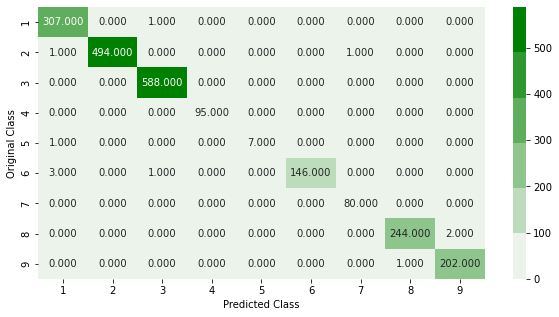

-------------------------------------------------- Precision matrix --------------------------------------------------


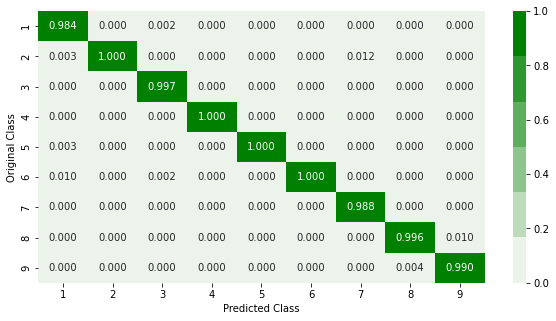

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


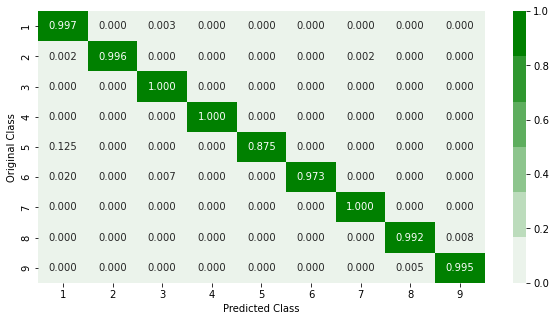

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:
plot_confusion_matrix(new_y_test,sig_clf.predict(x_test))

#XGBoost without size features

In [ ]:
import pandas as pd

In [ ]:
byte_unigram= pd.read_csv('result_with_size.csv',index_col='Unnamed: 0').drop(columns=['size'])
byte_bigram_top2k = pd.read_csv("byte_bigram_top2k.csv",header=None)
asm_unigram = pd.read_csv('asmoutputfile.csv')
asm_top_800 = pd.read_csv('asm_top_800.csv',header=None)


In [ ]:
df_list = [byte_unigram.drop(columns=['ID','Class']), #258
           byte_bigram_top2k,  #2000
           asm_unigram.drop(columns=['ID']), #51
           asm_top_800] #800

final_data = pd.concat(df_list,axis=1,ignore_index=True)
final_data.head(5)

,0,1,2,3,4,5,6,7,8,9,...,3098,3099,3100,3101,3102,3103,3104,3105,3106,3107
0,601905,3905,2816,3832,3345,3242,3650,3201,2965,3205,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
1,39755,8337,7249,7186,8663,6844,8420,7589,9291,358,...,56.0,54.0,32.0,40.0,80.0,69.0,41.0,13.0,10.0,46.0
2,93506,9542,2568,2438,8925,9330,9007,2342,9107,2457,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0
3,21091,1213,726,817,1257,625,550,523,1078,473,...,109.0,111.0,100.0,101.0,108.0,32.0,102.0,108.0,97.0,116.0
4,19764,710,302,433,559,410,262,249,422,223,...,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0,61.0


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(final_data, byte_unigram['Class'],stratify=byte_unigram['Class'],test_size=0.20,random_state=0)

print('train',x_train.shape,y_train.shape)

print('test',x_test.shape,y_test.shape)

train (8694, 3108) (8694,)
test (2174, 3108) (2174,)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
le = LabelEncoder()
new_y_train = le.fit_transform(y_train)
new_y_test = le.transform(y_test)

In [ ]:
clf = XGBClassifier()
params={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}

ran_s_cv=RandomizedSearchCV(clf,param_distributions=params,n_jobs=-1)
ran_s_cv.fit(x_train, new_y_train)

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                    

In [ ]:
ran_s_cv.best_params_

{'subsample': 1,
 'n_estimators': 1000,
 'max_depth': 5,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

The train log loss is: 0.01026792790075894
The test log loss is: 0.035212625866441104
Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


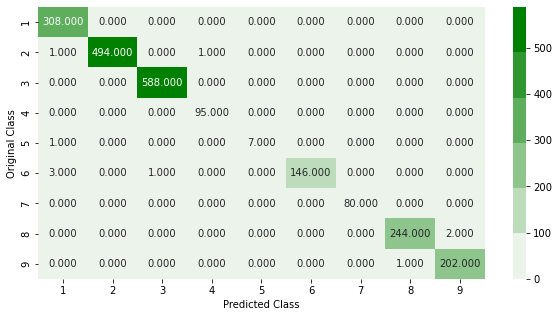

-------------------------------------------------- Precision matrix --------------------------------------------------


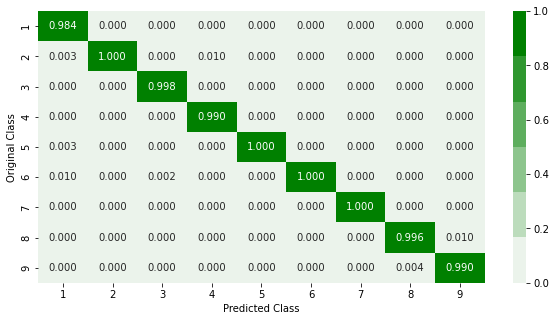

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


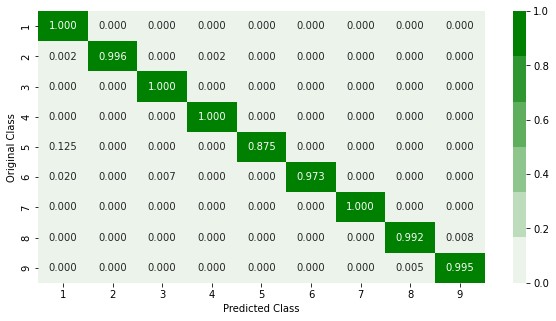

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
xgbclf = XGBClassifier(n_estimators=1000,max_depth=5,learning_rate=0.1,colsample_bytree=0.5,subsample=1,nthread=-1)
xgbclf.fit(x_train,new_y_train,verbose=True)

sig_clf = CalibratedClassifierCV(xgbclf, method="sigmoid")

sig_clf.fit(x_train, new_y_train)

predict_y = sig_clf.predict_proba(x_train)
print ( "The train log loss is:",log_loss(new_y_train, predict_y))

predict_y = sig_clf.predict_proba(x_test)
print("The test log loss is:",log_loss(new_y_test, predict_y))

plot_confusion_matrix(new_y_test,sig_clf.predict(x_test))


#Hyper parameter tuning for further reducing test loss

In [10]:
le = LabelEncoder()
new_y_train = le.fit_transform(y_train)
new_y_test = le.transform(y_test)

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.15, 'colsample_bytree': 0.5}

##Random search

In [ ]:

clf = XGBClassifier()
params={
    'learning_rate':[0.10,0.15,0.2],
     'n_estimators':[80,100,150],
     'max_depth':[8,10,12],
    'colsample_bytree':[0.4,0.5,0.6],
    'subsample':[0.4,0.5,0.6]
}

ran_s_cv=RandomizedSearchCV(clf,param_distributions=params,verbose=10,n_jobs=-1)
ran_s_cv.fit(x_train, new_y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           max_delta_step=None, max_depth=None,
                                   

In [ ]:
print(ran_s_cv.best_params_)

{'subsample': 0.6, 'n_estimators': 80, 'max_depth': 8, 'learning_rate': 0.15, 'colsample_bytree': 0.6}


In [ ]:
xgbclf = XGBClassifier(subsample=0.6,n_estimators=80,max_depth=8,learning_rate=0.15,colsample_bytree=0.6,nthread=-1)
xgbclf.fit(x_train,new_y_train,verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1, nthread=-1,
              num_parallel_tree=1, objective='multi:softprob', ...)

In [ ]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

In [ ]:
sig_clf = CalibratedClassifierCV(xgbclf, method="sigmoid")
sig_clf.fit(x_train, new_y_train)

predict_y = sig_clf.predict_proba(x_train)
print ( "The train log loss is:",log_loss(new_y_train, predict_y))

predict_y = sig_clf.predict_proba(x_test)
print("The test log loss is:",log_loss(new_y_test, predict_y))


The train log loss is: 0.01034335696751511
The test log loss is: 0.034601648327977644


Number of misclassified points  0.45998160073597055
-------------------------------------------------- Confusion matrix --------------------------------------------------


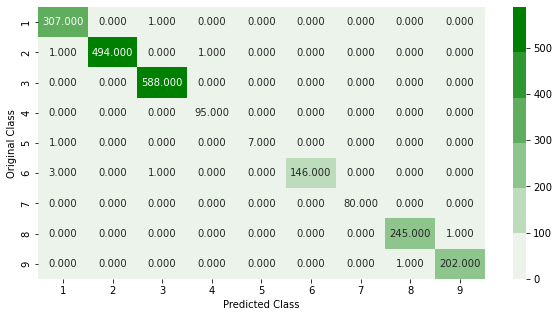

-------------------------------------------------- Precision matrix --------------------------------------------------


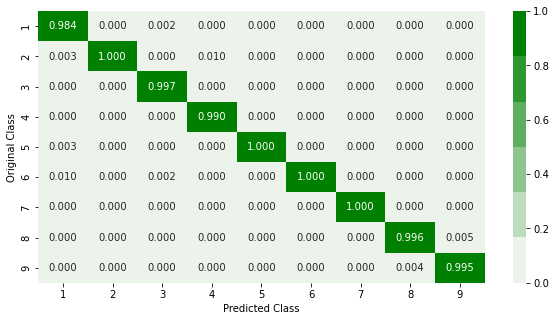

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


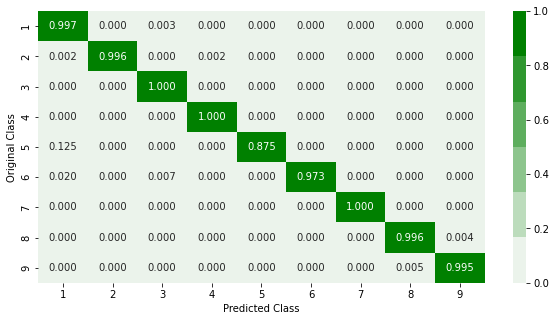

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
plot_confusion_matrix(new_y_test,sig_clf.predict(x_test))

##Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV

In [12]:
clf = XGBClassifier()
params={
    'learning_rate':[0.10,0.15,0.2],
     'n_estimators':[80,100,150],
     'max_depth':[8,10,12],
    'colsample_bytree':[0.4,0.5,0.6],
    'subsample':[0.4,0.5,0.6]
}


grid_s_cv=GridSearchCV(clf,param_grid=params,verbose=5)
grid_s_cv.fit(x_train, new_y_train)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.4;, score=0.993 total time= 1.3min
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.4;, score=0.993 total time= 1.3min
[CV 3/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.4;, score=0.994 total time= 1.3min
[CV 4/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.4;, score=0.992 total time= 1.3min
[CV 5/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.4;, score=0.994 total time= 1.3min
[CV 1/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.5;, score=0.994 total time= 1.4min
[CV 2/5] END colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=80, subsample=0.5;, score=0.994 total time= 1.5min
[CV 3/5] END colsam

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_b...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                

In [13]:
grid_s_cv.best_params_

{'colsample_bytree': 0.4,
 'learning_rate': 0.2,
 'max_depth': 8,
 'n_estimators': 80,
 'subsample': 0.5}

In [14]:
xgbclf = XGBClassifier(subsample=0.4,n_estimators=80,max_depth=8,learning_rate=0.2,colsample_bytree=0.4,nthread=-1)
xgbclf.fit(x_train,new_y_train,verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.4,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.2, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=8, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=80, n_jobs=-1, nthread=-1,
              num_parallel_tree=1, objective='multi:softprob', ...)

In [15]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss

In [16]:
sig_clf = CalibratedClassifierCV(xgbclf, method="sigmoid")
sig_clf.fit(x_train, new_y_train)

predict_y = sig_clf.predict_proba(x_train)
print ( "The train log loss is:",log_loss(new_y_train, predict_y))

predict_y = sig_clf.predict_proba(x_test)
print("The test log loss is:",log_loss(new_y_test, predict_y))

The train log loss is: 0.011201261700499208
The test log loss is: 0.03374344491778447
